In [1]:
#Importando bibliotecas a serem utilizadas

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [3]:
#Importando os dados

In [4]:
safra_ant = pd.read_csv("Safra_2018-2019.csv")
safra_atual = pd.read_csv("Safra_2020.csv")

In [5]:
# Visualizacao dos dados

In [6]:
safra_atual.head(15)

,Unnamed: 0,Identificador_Agricultor,Estimativa_de_Insetos,Tipo_de_Cultivo,Tipo_de_Solo,Categoria_Pesticida,Doses_Semana,Semanas_Utilizando,Semanas_Sem_Uso,Temporada
0,80000,SCROP80001,256,0,1,2,35,11.0,9,1
1,80001,SCROP80002,283,0,1,2,5,5.0,6,1
2,80002,SCROP80003,283,0,1,2,15,15.0,5,2
3,80003,SCROP80004,283,0,1,2,15,NaN,7,2
4,80004,SCROP80005,283,0,1,2,15,19.0,2,1
5,80005,SCROP80006,283,0,1,2,30,11.0,7,3
6,80006,SCROP80007,311,0,1,2,10,7.0,9,1
7,80007,SCROP80008,311,0,1,2,20,19.0,7,2
8,80008,SCROP80009,312,0,1,2,25,12.0,12,3
9,80009,SCROP80010,311,0,1,2,30,18.0,2,3


In [7]:
safra_ant.head(15)

,Unnamed: 0,Identificador_Agricultor,Estimativa_de_Insetos,Tipo_de_Cultivo,Tipo_de_Solo,Categoria_Pesticida,Doses_Semana,Semanas_Utilizando,Semanas_Sem_Uso,Temporada,dano_na_plantacao
0,0,SCROP00001,188,1,0,1,0,0.0,0,1,0
1,1,SCROP00002,209,1,0,1,0,0.0,0,2,1
2,2,SCROP00003,257,1,0,1,0,0.0,0,2,1
3,3,SCROP00004,257,1,1,1,0,0.0,0,2,1
4,4,SCROP00005,342,1,0,1,0,0.0,0,2,1
5,5,SCROP00006,448,0,1,1,0,NaN,0,2,1
6,6,SCROP00007,448,0,1,1,0,NaN,0,2,1
7,7,SCROP00008,577,1,0,1,0,0.0,0,1,2
8,8,SCROP00009,731,0,0,1,0,0.0,0,2,0
9,9,SCROP00010,1132,1,0,1,0,0.0,0,1,2


In [8]:
# verificando a quantidade de dados que temos

In [9]:
safra_atual.shape

(8858, 10)

In [10]:
safra_ant.shape

(80000, 11)

In [11]:
# Tratando os valores Nan que apareceram em ambos os dataframes

In [12]:
 safra_ant['Semanas_Utilizando']=np.nan_to_num(safra_ant['Semanas_Utilizando'])

In [13]:
safra_ant.head(25)

,Unnamed: 0,Identificador_Agricultor,Estimativa_de_Insetos,Tipo_de_Cultivo,Tipo_de_Solo,Categoria_Pesticida,Doses_Semana,Semanas_Utilizando,Semanas_Sem_Uso,Temporada,dano_na_plantacao
0,0,SCROP00001,188,1,0,1,0,0.0,0,1,0
1,1,SCROP00002,209,1,0,1,0,0.0,0,2,1
2,2,SCROP00003,257,1,0,1,0,0.0,0,2,1
3,3,SCROP00004,257,1,1,1,0,0.0,0,2,1
4,4,SCROP00005,342,1,0,1,0,0.0,0,2,1
5,5,SCROP00006,448,0,1,1,0,0.0,0,2,1
6,6,SCROP00007,448,0,1,1,0,0.0,0,2,1
7,7,SCROP00008,577,1,0,1,0,0.0,0,1,2
8,8,SCROP00009,731,0,0,1,0,0.0,0,2,0
9,9,SCROP00010,1132,1,0,1,0,0.0,0,1,2


In [14]:
safra_atual['Semanas_Utilizando'] = np.nan_to_num(safra_atual['Semanas_Utilizando'])

In [15]:
# Vizualizando os tipos de danos que existem na coluna danos a plantacao

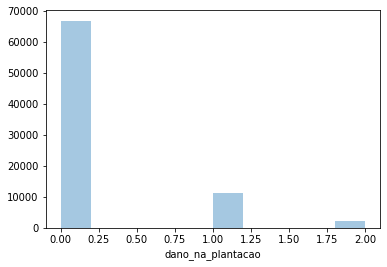

In [16]:
sns.distplot(safra_ant["dano_na_plantacao"],bins = 10,kde = False)

In [17]:
#Com esse grafico percebemos que temos resultados discretos

In [18]:
#Assim teremos que utilizar algum algoritmo de classificacao

In [19]:
# Vamos usar o algoritmo RandomForestClassifier

In [20]:
#Selecionando os dados a serem modelados

In [21]:
X = safra_ant[safra_ant.columns[ 2:-1]]
X.head(25)

,Estimativa_de_Insetos,Tipo_de_Cultivo,Tipo_de_Solo,Categoria_Pesticida,Doses_Semana,Semanas_Utilizando,Semanas_Sem_Uso,Temporada
0,188,1,0,1,0,0.0,0,1
1,209,1,0,1,0,0.0,0,2
2,257,1,0,1,0,0.0,0,2
3,257,1,1,1,0,0.0,0,2
4,342,1,0,1,0,0.0,0,2
5,448,0,1,1,0,0.0,0,2
6,448,0,1,1,0,0.0,0,2
7,577,1,0,1,0,0.0,0,1
8,731,0,0,1,0,0.0,0,2
9,1132,1,0,1,0,0.0,0,1


In [22]:
Y = safra_ant["dano_na_plantacao"]
Y.head()

0    0
1    1
2    1
3    1
4    1
Name: dano_na_plantacao, dtype: int64

In [23]:
#dividindo em dados de treino e dados de teste

In [24]:
X_treino,X_teste,Y_treino,Y_teste = train_test_split(X,Y,test_size =0.33,random_state =1)

In [25]:
modelo = RandomForestClassifier(random_state =1)

In [26]:
#Treinando o modelo

In [27]:
modelo.fit(X_treino,Y_treino)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [28]:
#Usando o modelo para prever os dados de teste e depois comparando com os resultados reais

In [29]:
yhat = modelo.predict(X_teste)

In [30]:
acc = accuracy_score(Y_teste, yhat)
print('Acuracia: %.3f' % acc)

Acuracia: 0.822


In [31]:
#Separando os inputs que serao usados para prever a safra de 2020

In [32]:
x_final = safra_atual[safra_atual.columns[2:]]

In [33]:
x_final.head(25)

,Estimativa_de_Insetos,Tipo_de_Cultivo,Tipo_de_Solo,Categoria_Pesticida,Doses_Semana,Semanas_Utilizando,Semanas_Sem_Uso,Temporada
0,256,0,1,2,35,11.0,9,1
1,283,0,1,2,5,5.0,6,1
2,283,0,1,2,15,15.0,5,2
3,283,0,1,2,15,0.0,7,2
4,283,0,1,2,15,19.0,2,1
5,283,0,1,2,30,11.0,7,3
6,311,0,1,2,10,7.0,9,1
7,311,0,1,2,20,19.0,7,2
8,312,0,1,2,25,12.0,12,3
9,311,0,1,2,30,18.0,2,3


In [34]:
#prevendo os resultados

In [35]:
y_final = modelo.predict(x_final)

In [36]:
print(y_final)

[0 0 0 ... 0 0 0]


In [37]:
#Adicionando os resultados previstos a tabela da safra de 2020

In [38]:
safra_atual.insert(loc = 10, column = "dano_na_plantacao", value = y_final)
safra_atual.head(20)

,Unnamed: 0,Identificador_Agricultor,Estimativa_de_Insetos,Tipo_de_Cultivo,Tipo_de_Solo,Categoria_Pesticida,Doses_Semana,Semanas_Utilizando,Semanas_Sem_Uso,Temporada,dano_na_plantacao
0,80000,SCROP80001,256,0,1,2,35,11.0,9,1,0
1,80001,SCROP80002,283,0,1,2,5,5.0,6,1,0
2,80002,SCROP80003,283,0,1,2,15,15.0,5,2,0
3,80003,SCROP80004,283,0,1,2,15,0.0,7,2,0
4,80004,SCROP80005,283,0,1,2,15,19.0,2,1,0
5,80005,SCROP80006,283,0,1,2,30,11.0,7,3,0
6,80006,SCROP80007,311,0,1,2,10,7.0,9,1,0
7,80007,SCROP80008,311,0,1,2,20,19.0,7,2,0
8,80008,SCROP80009,312,0,1,2,25,12.0,12,3,0
9,80009,SCROP80010,311,0,1,2,30,18.0,2,3,0


In [39]:
#Plotando resultados

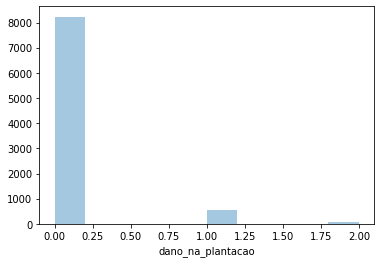

In [40]:
sns.distplot(safra_atual["dano_na_plantacao"],bins = 10,kde = False)